<a href="https://colab.research.google.com/github/deepshikharbhardwaj/Machine_Learning/blob/main/Fashion_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
# define constants
NUM_EPOCHS = 10
BATCH_SIZE = 4
LEARNING_RATE = 0.001

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, 
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, 
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle Boot')

torch.Size([4, 1, 28, 28])
torch.Size([4])


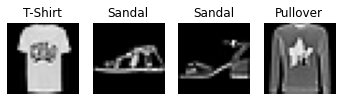

In [6]:
for batch_1 in trainloader:
    batch = batch_1
    break
print(batch[0].shape) # as batch[0] contains the image pixels -> tensors
print(batch[1].shape) # batch[1] contains the labels -> tensors
plt.figure(figsize=(12, 8))
for i in range (batch[0].shape[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
    plt.title(classes[batch[1][i]])
    plt.savefig('fashion_mnist.png')
plt.show()

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                               kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [9]:
# if GPU is available, then use GPU, else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cpu


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# function to calculate accuracy
def calc_acc(loader):
    correct = 0
    total = 0
    for data in loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return ((100*correct)/total)

In [11]:
def train():
    epoch_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # set parameter gradients to zero
            optimizer.zero_grad()
            # forward pass
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss.append(running_loss/15000)
        train_acc.append(calc_acc(trainloader))
        test_acc.append(calc_acc(testloader))
        print('Epoch: %d of %d, Train Acc: %0.3f, Test Acc: %0.3f, Loss: %0.3f'
              % (epoch+1, NUM_EPOCHS, train_acc[epoch], test_acc[epoch], running_loss/15000))
        
    return epoch_loss, train_acc, test_acc

In [12]:
start = time.time()
epoch_loss, train_acc, test_acc = train()
end = time.time()
print('%0.2f minutes' %((end - start) / 60))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 of 10, Train Acc: 84.305, Test Acc: 83.090, Loss: 0.652
Epoch: 2 of 10, Train Acc: 87.447, Test Acc: 86.570, Loss: 0.391
Epoch: 3 of 10, Train Acc: 88.808, Test Acc: 87.460, Loss: 0.339
Epoch: 4 of 10, Train Acc: 88.788, Test Acc: 87.190, Loss: 0.310
Epoch: 5 of 10, Train Acc: 89.980, Test Acc: 88.320, Loss: 0.292
Epoch: 6 of 10, Train Acc: 88.983, Test Acc: 87.050, Loss: 0.275
Epoch: 7 of 10, Train Acc: 91.367, Test Acc: 88.940, Loss: 0.263
Epoch: 8 of 10, Train Acc: 91.755, Test Acc: 88.860, Loss: 0.250
Epoch: 9 of 10, Train Acc: 91.817, Test Acc: 88.920, Loss: 0.241
Epoch: 10 of 10, Train Acc: 91.523, Test Acc: 88.600, Loss: 0.232
14.89 minutes


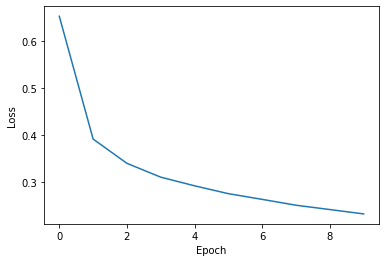

In [13]:
plt.figure()
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('fashion_loss.png')
plt.show()

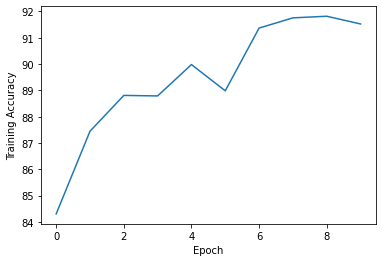

In [14]:
plt.figure()
plt.plot(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.savefig('fashion_train_acc.png')
plt.show()

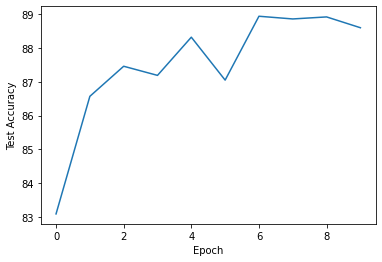

In [15]:
plt.figure()
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.savefig('fashion_test_acc.png')
plt.show()